In [0]:
#pip install fbprophet

In [0]:
import logging
logger = spark._jvm.org.apache.log4j
logging.getLogger("py4j.java_gateway").setLevel(logging.ERROR)

In [0]:
#import 
import mlflow
import mlflow.sklearn
#experiment_name 
experiment_name = '/Users/amani.ellafi@inetum.com/simplon/ProjetE1/Models_token'
#Pour configurer une nouvelle expérience, il faut indiquer un nouveau nom d’expérience
mlflow.set_experiment(experiment_name)

Out[2]: <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1649134493054697', experiment_id='1649134493054697', lifecycle_stage='active', name='/Users/amani.ellafi@inetum.com/simplon/ProjetE1/Models_token', tags={'mlflow.experiment.sourceName': '/Users/amani.ellafi@inetum.com/simplon/ProjetE1/Models_token',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'amani.ellafi@inetum.com',
 'mlflow.ownerId': '3146070342342934'}>

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.layers import Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from prophet import Prophet


#### table info_token

In [0]:
#recuper les données à partir la base de données
data= sqlContext.table("token_db.info_token")

In [0]:
# path = '/mnt/datalake/tmp/amani/data_token/data_info_token3'
# data = spark.read.parquet(path)

#### Les fonctions

In [0]:
#mise à jour les données pour tenir en compte l'aggregation que j'ai fait initialement 
def updating_data(data):
  data=data.groupby("token").agg(min("date_premiere_cap").alias("date_premiere_cap"),
                                max("date_derniere_cap").alias("date_derniere_cap"),
                                sum("Age_token_mois").alias("Age_token_mois"),
                                 sum("nombre_trajet").alias("nombre_trajet"),
                                 sum("nombre_km").alias("nombre_km"),
                                 sum("nombre_nodes").alias("nombre_nodes"),
                                 max("temps_inactivite_max_entre_2trajets").alias("temps_inactivite_max_entre_2trajets"),
                                 sum("temps_inactivite_mois").alias("temps_inactivite_mois"))

  return data

In [0]:
#ajouter les colonnes profil_utilisateur,confinement
def add_columns(data):
  #0 actif , 1 inactif 
  data_processing=(data.withColumn("profil_utilisateur",when(col("temps_inactivite_mois")<5,0).otherwise(1))
                      #ajouter la colonne de confinement 
                      .withColumn("confinement",
                                   when(((data.date_premiere_cap>="2020-03-17" )& (data.date_premiere_cap<="2020-05-10" ))
                                  |((data.date_premiere_cap>="2020-10-30" )& (data.date_premiere_cap<="2020-12-15" ))
                                  |((data.date_premiere_cap>="2021-04-03" )& (data.date_premiere_cap<="2021-05-03" )),True)
                                  .otherwise(False))
                       .withColumn("recrutement",
                                  when((data.date_premiere_cap.contains("2019-04"))
                                  |(data.date_premiere_cap.contains("2019-05"))
                                  |(data.date_premiere_cap.contains("2020-07"))
                                  |(data.date_premiere_cap.contains("2020-01"))
                                  |(data.date_premiere_cap.contains("2020-09"))
                                  |(data.date_premiere_cap.contains("2021-09"))
                                  |(data.date_premiere_cap.contains("2022-05"))
                                  |(data.date_premiere_cap.contains("2022-08"))
                                  |(data.date_premiere_cap.contains("2022-09"))
                                  |(data.date_premiere_cap.contains("2022-10")),1)
                                  .otherwise(0))
                  )
  return data_processing

In [0]:
#resample data  suivant le variable "resample"(suivant le jour , semaine, mois ...)
def group_data(df,resample):
  df['date_premiere_cap'] = pd.to_datetime(df['date_premiere_cap'])
  df=df.set_index("date_premiere_cap")
  daily_data=df.resample(resample).agg({'nombre_trajet':'sum',
                                          #'nombre_device':'sum',
                                          'nombre_km':'sum',
                                          'temps_inactivite_max_entre_2trajets':'sum',
                                          'Age_token_mois':'sum',
                                          'temps_inactivite_mois':'sum',
                                          'token':'count',
                                          'profil_utilisateur':'sum',
                                           'confinement':'sum',
                                      "recrutement":"sum"
                                       }
                                        )
  return daily_data

In [0]:
#ajouter la tendance pour le nombre de token si il va augmenter ou non , recrutement
def add_token_tendance(df):
  df["token_tend"] = df["token"].diff()
  df['token_tendance'] = np.where(df["token_tend"]<0, 0, 1)
  return df

In [0]:
def train_test_split(data):
    size=int(len(data)*0.7)
    train =data.iloc[0:size] 
    test = data.iloc[size:] 
    return train, test

In [0]:
def model_ARIMA(data):
  train,test=train_test_split(data)
  scaler =  StandardScaler()
  X_train = scaler.fit_transform(train.drop('profil_utilisateur',axis=1))
  X_test = scaler.transform(test.drop('profil_utilisateur',axis=1))
  y_train = scaler.fit_transform(train["profil_utilisateur"].values.reshape(-1, 1)).reshape(-1, )
  y_test = scaler.transform(test["profil_utilisateur"].values.reshape(-1, 1)).reshape(-1, )
  model = pm.auto_arima(y_train, X_train,
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=None,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
 
  model.fit(y_train,X_train)
  #predict train
  forecast_train_sc = model.predict(len(X_train),X_train)
  #inverse_transform train
  forecast_train = scaler.inverse_transform(forecast_train_sc.reshape(-1, 1)).reshape(-1, )
  train["Forecast_ARIMAX"] = forecast_train 
  #predict test
  forecast_test_sc = model.predict(len(X_test),X_test)
  #inverse_transform train
  forecast_test = scaler.inverse_transform(forecast_test_sc.reshape(-1, 1)).reshape(-1, )
  test["Forecast_ARIMAX"] = forecast_test
  return train,test,model

In [0]:
def fb_model(data):
  # copy data
  df_fb = data.copy()
  df_fb=df_fb.reset_index()

  # Specify the column names for the date and the target variable
  df_fb.rename(columns={'date_premiere_cap': 'ds', 'profil_utilisateur': 'y'}, inplace=True)

  #split data
  train,test=train_test_split(df_fb)

  #train
  X_fb_train=train.drop('y',axis=1)
  y_fb_train=train.y

  #test
  X_fb_test=test.drop('y',axis=1)
  y_fb_test=test.y



  # Create a Prophet object and fit the model

  m = Prophet()
  m.fit(train)


  # Use the Prophet object to make predictions, including the exogenous variables
  forecast = m.predict(X_fb_test)
  test["Forecast_Prophet"] = forecast.yhat.values
  return test,m

In [0]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    r2=r2_score(actual,forecast)
    #return({'mape':mape, 'mae': mae, 'rmse':rmse,'r2':r2})
    return mae,rmse,r2

In [0]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [0]:
def round_data(data):
  data.Age_token_mois = np.round(data.Age_token_mois,decimals = 2) 
  data.nombre_km = np.round(data.nombre_km,decimals = 2) 
  return data 

#### Appel les fonctions

In [0]:
data_update=updating_data(data)
data_add_columns=add_columns(data_update)

##### ToPandas()

In [0]:
#to pandas 
df_pandas= data_add_columns.toPandas()

In [0]:
daily_data=group_data(df_pandas,resample="D")

In [0]:
data_token_tendance=add_token_tendance(daily_data)
#s'il y a la confinement ou non (0 ou 1 )
data_token_tendance['confinement'] = np.where(data_token_tendance['confinement']!=0, 1, 0)
#s'il y a un recrutement ou non (0 ou 1 )
data_token_tendance['recrutement'] = np.where(data_token_tendance['recrutement']!=0, 1, 0)


In [0]:

# figure1, ax = plt.subplots(2,4, figsize = (25,25))
# for i, j in enumerate(daily_data.columns[daily_data.dtypes != 'object']):
#     sns.distplot(daily_data[j], fit=norm, ax = ax[i//4, i%4])
# figure1.text(0.4,.92, 'Distribution of numerical features', size = 25, weight = 'bold')
# plt.show(figure1)

#### Data Model

In [0]:
data_round= round_data(daily_data)
data_model=data_round.drop(["token","token_tend",'recrutement'],axis=1)
#df_fb=data_model.reset_index().rename(columns={'date_premiere_cap': 'ds', 'profil_utilisateur': 'y'})
data_model.columns

Out[20]: Index(['nombre_trajet', 'nombre_km', 'temps_inactivite_max_entre_2trajets',
 'Age_token_mois', 'temps_inactivite_mois', 'profil_utilisateur',
 'confinement', 'token_tendance'],
 dtype='object')

In [0]:
# data_test=data_model[["date_premiere_cap","temps_inactivite_mois","Age_token_mois","confinement","profil_utilisateur","token_tendance","nombre_trajet","nombre_km","temps_inactivite_max_entre_2trajets"]]

In [0]:
def fb_model2(data):
  # copy data
  df_fb = data.copy()
  df_fb=df_fb.reset_index()

  # Specify the column names for the date and the target variable
  df_fb.rename(columns={'date_premiere_cap': 'ds', 'profil_utilisateur': 'y'}, inplace=True)

  #split data
  train,test=train_test_split(df_fb)

  exogenous_features=train.drop(["ds","y"],axis=1)



  # Create a Prophet object and fit the model

  model = Prophet()
  for feature in exogenous_features:
    model.add_regressor(feature)
  model.fit(train)


  # Use the Prophet object to make predictions, including the exogenous variables
  forecast=model.predict(test)  
  test["Forecast_Prophet"] = forecast.yhat.values
  return test,model

#### split data

In [0]:
df_train,df_test=train_test_split(data_model)

#### Best model

In [0]:

import mlflow
logged_model = 'runs:/0c335ce273d34b0e9f8493396b88c74a/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd


#### LSTM

In [0]:
train,test=train_test_split(data_model)
df_lstm=data_model.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
y_train = scaler.fit_transform(train["profil_utilisateur"].values.reshape(-1, 1)).reshape(-1, )
y_test = scaler.transform(test["profil_utilisateur"].values.reshape(-1, 1)).reshape(-1, )
n_input = 4
n_features=train.shape[1]
#TimeseriesGenerator for train data
train_generator = TimeseriesGenerator(X_train,y_train, length=n_input,batch_size=8)
#TimeseriesGenerator for test data
test_generator = TimeseriesGenerator(X_test,y_test, length=n_input,batch_size=8)
#model
model=Sequential() 
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True, name="lstm_2")) 
model.add(LSTM(25,activation='relu',return_sequences=True, name="lstm_3")) 
model.add(LSTM(25,activation='relu',return_sequences=False, name="lstm_4"))
model.add(Dense(1, name="dense"))
model.compile(optimizer="rmsprop", loss='mse')
history = model.fit(train_generator, epochs=100,
                validation_data=test_generator,
                shuffle=False,batch_size=64)




In [0]:
trainY = get_y_from_generator(train_generator)
testY = get_y_from_generator(test_generator)
trainPredict =model.predict(train_generator)
testPredict =model.predict(test_generator)


#### Hyperopt

In [0]:
#{'batch_size': 16.0, 'epochs': 40.0, 'layers': 2.0, 'rate': 0.4609708003426465, 'units': 20.0}
train,test=train_test_split(data_model)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
y_train = scaler.fit_transform(train["profil_utilisateur"].values.reshape(-1, 1)).reshape(-1, )
y_test = scaler.transform(test["profil_utilisateur"].values.reshape(-1, 1)).reshape(-1, )
n_input = 20
n_features=train.shape[1]
#TimeseriesGenerator for train data
train_generator = TimeseriesGenerator(X_train,y_train, length=n_input,batch_size=8)
#TimeseriesGenerator for test data
test_generator = TimeseriesGenerator(X_test,y_test, length=n_input,batch_size=8)
#model
model=Sequential() 
model.add(LSTM(20,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(20,activation='relu',return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, name="dense"))
model.compile(optimizer="rmsprop", loss='mse')
history = model.fit(train_generator, epochs=40,
                validation_data=test_generator,
                shuffle=False,batch_size=16)

In [0]:
trainY = get_y_from_generator(train_generator)
testY = get_y_from_generator(test_generator)
trainPredict_hyper =model.predict(train_generator)
testPredict_hyper =model.predict(test_generator)

### Test

In [0]:
# # Importez les modules nécessaires
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX


# # Spécifiez les paramètres de l'algorithme ARIMAX
# p = 1
# d = 0
# q = 0

# # Créez un modèle ARIMAX en spécifiant les paramètres p, d, et q
# model = SARIMAX(y_train,X_train, order=(p, d, q))

# # Entraînez le modèle ARIMAX en utilisant les données d'entraînement
# model.fit()

# # Prédisez les données de test en utilisant le modèle entraîné
# predictions = model.fit().predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
# forecast_test = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, )
# test["Forecast_ARIMAX"] = forecast_test
# plt.plot(y_test, label="Données réelles")
# plt.plot(predictions, label="Valeurs prédites")
# plt.xlabel("Temps")
# plt.ylabel("Valeur")
# plt.legend()
# plt.show()


### MLflow ARIMA

In [0]:
import mlflow
mlflow.autolog()
with mlflow.start_run(run_name="ARIMA sans columns") as run:
    train,test,model=model_ARIMA(data_model)
    mlflow.log_metric("testScore_mae",mean_absolute_error(test["profil_utilisateur"],test["Forecast_ARIMAX"]))
    mlflow.log_metric("testScoreRMSE", np.sqrt(mean_squared_error(test["profil_utilisateur"],test["Forecast_ARIMAX"])))
    mlflow.log_metric("testScoreR2", r2_score(test["profil_utilisateur"],test["Forecast_ARIMAX"]))
    mlflow.sklearn.log_model(model,"model ARIMAX")
#mlflow.end_run()


2023/01/23 12:46:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/01/23 12:46:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/01/23 12:46:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2023/01/23 12:46:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/01/23 12:46:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
Performing stepwise search to minimize aic
2023/01/23 12:46:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(0,0,0)(0,0,0)[0] : AIC=-378.665, Time=0.48 sec
2023/01/23 12:46:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(1,0,0)(0,0,0)[0] : AIC=-503.998, Time=1.05 sec
2023/01/23 12:46:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(0,0,1)(0,0,0)[0] : AIC=-429.272, Time=1.20 sec
2023/01/23 12:46:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(2,0,0)(0,0,0)[0] : AIC=-617.101, Time=1.72 sec
2023/01/23 12:46:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(3,0,0)(0,0,0)[0] : AIC=-645.591, Time=1.90 sec
2023/01/23 12:46:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(3,0,1)(0,0,0)[0] : AIC=-647.284, Time=2.30 sec
2023/01/23 12:46:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(2,0,1)(0,0,0)[0] : AIC=-645.857, Time=1.90 sec
2023/01/23 12:46:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(3,0,2)(0,0,0)[0] : AIC=-653.240, Time=2.41 sec
2023/01/23 12:46:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(2,0,2)(0,0,0)[0] : AIC=-651.649, Time=2.22 sec
2023/01/23 12:46:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(3,0,3)(0,0,0)[0] : AIC=-654.039, Time=3.27 sec
2023/01/23 12:46:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during statsmodels autologging: INVALID_PARAMETER_VALUE: Parameter with key cov_type was already logged with a value of nonrobust. The attempted new value was None
 ARIMA(2,0,3)(0,0,0)[0] : AIC=-650.045, Time=2.59 sec
2023/01/23 12:47:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during

In [0]:
test[["profil_utilisateur","Forecast_ARIMAX"]].plot(figsize=(20,10))


### MLflow FBprophet

In [0]:
# plt.plot(figsize=(20,20))
# #plt.plot(train.ds,train.y,color='green',label='train')
# plt.plot(test.ds,test.y,color='blue',label='test')
# plt.plot(test.ds,test.Forecast_Prophet,color='red',label='Forecast_Prophet')
# plt.legend()

In [0]:
import mlflow
#mlflow.autolog()
with mlflow.start_run(run_name="FBprophet") as run:
    test_fb,model=fb_model2(data_model)
    mlflow.log_metric("testScore_mae",mean_absolute_error(test_fb.y,test_fb['Forecast_Prophet']))
    mlflow.log_metric("testScoreRMSE", np.sqrt(mean_squared_error(test_fb.y,test_fb['Forecast_Prophet'])))
    mlflow.log_metric("testScoreR2", r2_score(test_fb.y,test_fb['Forecast_Prophet']))
    mlflow.sklearn.log_model(model,"model FB")
#mlflow.end_run()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<command-1635676893001719>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 test["Forecast_Prophet"] = forecast.yhat.values

In [0]:
import mlflow
#mlflow.autolog()
with mlflow.start_run(run_name="FBprophet+données exogenes") as run:
    test_fb,model=fb_model2(data_model)
    #mlflow.log_metric("testScore_mae",mean_absolute_error(test_fb.y,test_fb['Forecast_Prophet']))
    #mlflow.log_metric("testScoreRMSE", np.sqrt(mean_squared_error(test_fb.y,test_fb['Forecast_Prophet'])))
    mlflow.log_metric("testScoreR2", r2_score(test_fb.y,test_fb['Forecast_Prophet']))
    mlflow.sklearn.log_model(model,"model FB2")
#mlflow.end_run()

In [0]:
plt.figure(figsize=(15,10))
plt.plot(test_fb.ds,test_fb.y,label='Forecast_Prophet')
plt.plot(test_fb.ds,test_fb.Forecast_Prophet,label='Forecast_Prophet')


### Récap

In [0]:
#ajouter le resultat de hyperopt dans data test
test_hyper=[None]*len(df_test)
test_hyper[n_input: ] = testPredict_hyper.reshape(-1)
df_test["Forecast_hyper_opt"]=test_hyper

In [0]:
# #ajouter le resultat de lstm dans data test
# test_lstm=[None]*len(df_test)
# test_lstm[n_input: ] = testPredict.reshape(-1)
# df_test["Forecast_lstm"]=test_lstm
#ajouter ARIMAX
df_test["Forecast_ARIMAX"]=test["Forecast_ARIMAX"]
#ajouter le resultat de FB 
df_test["Forecast_fb"]=test_fb['Forecast_Prophet']

<command-1635676893001743>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df_test["Forecast_ARIMAX"]=test["Forecast_ARIMAX"]
<command-1635676893001743>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df_test["Forecast_fb"]=test_fb['Forecast_Prophet']

In [0]:
#df_test[["profil_utilisateur","Forecast_lstm","Forecast_hyper_opt"]].plot(figsize=(15,10))


Out[37]:

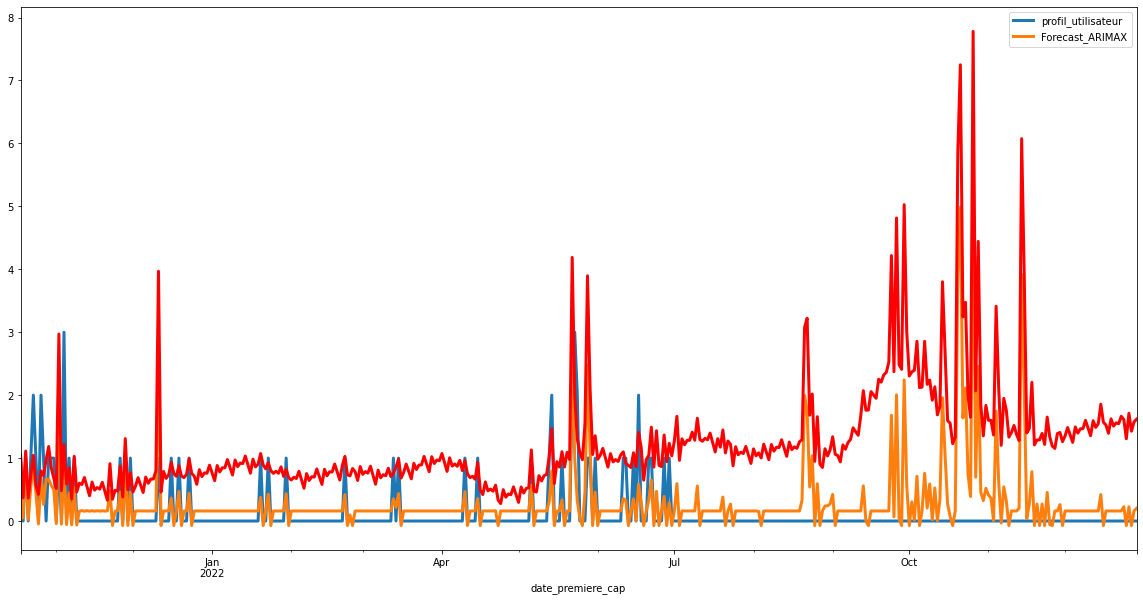

[<matplotlib.lines.Line2D at 0x7f5354081c40>]

In [0]:
df_test[["profil_utilisateur","Forecast_ARIMAX"]].plot(figsize=(20,10),linewidth=3)

plt.plot(test_fb.ds,test_fb.Forecast_Prophet,color='red',label='Forecast_Prophet',linewidth=3)

In [0]:
df_test[["profil_utilisateur","Forecast_ARIMAX","Forecast_fb"]].plot(figsize=(20,10))
plt.plot(test_fb.ds,test_fb.Forecast_Prophet,color='red',label='Forecast_Prophet')
